# Introduction
In this file, I am just gonna go step by step to create the LSTM Model and see what problems our data has, as well as making a roadmap for things we need to do.


### Roadmap
TODO:
- write here upcoming tasks

DONE:

# Data prepocessing



In [1]:
pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18912 sha256=e59defabc0feead0b23c5d42591e8eefc3c0ac176e040fd862ebabd71e197817
  Stored in directory: /root/.cache/pip/wheels/95/b1/a8/5ee00cc137940b2f6fa198212e8f45d813d0e0d9c3a04035a3
Successfully built keras-self-attention


In [2]:
# Data imports
import pandas as pd
import numpy as np
import datetime
import os, sys
from pathlib import Path
from google.colab import drive
# ML Imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, Conv1D, MaxPooling1D, Attention
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_self_attention import SeqSelfAttention
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


In [3]:
# mount drive
drive.mount('/content/drive')
path = Path('/content/drive/MyDrive/aviation 2021-2022 (little aviators)')
os.chdir(path) # sets directory to "path"
os.getcwd() # prints directory

Mounted at /content/drive


'/content/drive/.shortcut-targets-by-id/1uymUnd-PIBOCF-bgNspWN4-OmEQKoU0s/aviation 2021-2022 (little aviators)'

In [4]:
def buildTrain(training_data, features, Y_feature, pastDay=300, futureDay=300):
  l = training_data.shape[0]-futureDay-pastDay

  X_train = np.zeros(shape=(l,pastDay, len(features)))
  Y_train = np.zeros(shape=(l,futureDay))

  for i in range(l):
    X_train[i] = np.array(training_data.iloc[i:i+pastDay][features])
    Y_train[i] = np.array(training_data.iloc[i+pastDay:i+pastDay+futureDay][Y_feature])
  return np.array(X_train), np.array(Y_train)

def shuffle(X,Y):
  np.random.seed(10)
  randomList = np.arange(X.shape[0])
  np.random.shuffle(randomList)
  return X[randomList], Y[randomList]

def splitData(X,Y,rate):
  X_train = X[int(X.shape[0]*rate):]
  Y_train = Y[int(Y.shape[0]*rate):]
  X_val = X[:int(X.shape[0]*rate)]
  Y_val = Y[:int(Y.shape[0]*rate)]
  return X_train, Y_train, X_val, Y_val
def buildOneToOneModel(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2],return_sequences=True))
  # output shape: (1, 1)
  model.add(TimeDistributed(Dense(1)))    # or use model.add(Dense(1))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

def buildManyToManyModel(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2], return_sequences=True))
  model.add(SeqSelfAttention(attention_activation='sigmoid'))
  # output shape: (5, 1)
  model.add(TimeDistributed(Dense(1)))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

def cnnpred_2d(seq_len=60, n_features=82, n_filters=(8,8,8), droprate=0.1):
  model = Sequential([
        Input(shape=(seq_len, n_features, 1)),
        Conv2D(n_filters[0], kernel_size=(1, n_features), activation="relu"),
        Conv2D(n_filters[1], kernel_size=(3,1), activation="relu"),
        MaxPool2D(pool_size=(2,1)),
        Conv2D(n_filters[2], kernel_size=(3,1), activation="relu"),
        MaxPool2D(pool_size=(2,1)),
        Flatten(),
        Dropout(droprate),
        Dense(1, activation="sigmoid")
    ])
  model.compile(optimizer="adam", loss="mse")
  model.summary()
  return model


def cnn_1d(n_steps=60, n_features=82):
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(50, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  model.summary()

  return model

In [5]:
selected = ['Body Type',
 'Manufacturer',
 'Plane Type',
 'Sub-Type',
 'Year of Delivery',
 'CFMV',
 'CBV',
 'Passenger / Freighter',
 'Family',
 'Family Count',
 'Earliest Record Age',
 'date',
 'Revenue Pass. Miles (mil.)',
 'Available Seat Miles (mil.)',
 'Load Factor',
 'Revenue Miles (000s)',
 'Revenue Hours',
 'Block Hours',
 'Aircraft Days',
 'Revenue Departures',
 'Gallons of Fuel (000s)',
 'Number of Aircraft',
 'Flying Labor Expense ($000s)',
 'Fuel Expense ($000s)',
 'Total Flying Expense ($000s)',
 'Direct Maint. - Airframe ($000s)',
 'Direct Maint. - Engines ($000s)',
 'Total Direct Maintenance ($000s)',
 'Maintenance Burden ($000s)',
 'Depreciation ($000s)',
 'Aircraft Rent ($000s)',
 'Total Aircraft Operating Exp. ($000s)',
 'Flying Labor Cost',
 'Fuel Cost',
 'Other Costs',
 'Total Flying Cost',
 'Direct Maint. - Airframe',
 'Direct Maint. - Engines',
 'Total Direct Maintenance',
 'Maintenance Burden',
 'Total Maintenance Costs',
 'Depreciation',
 'Aircraft Rent',
 'Total Cost per Block Hour',
 'Cost per Available Seat Mile - ¢',
 'Fuel Cost per ASM - ¢',
 'Total Cost per ASM ex. fuel - ¢',
 'Utilization - Block Hours per Day',
 'Speed - Miles per Block Hour',
 'Seats per Aircraft',
 'Gallons of Fuel per Block Hour',
 'Gallons per Block Hour per Seat',
 'Fuel Cost per Gallon - $',
 'Average Flight Stage - miles',
 'Fuel lbs./ASM',
 'Gallons per Revenue Mile']
need_to_std = ['Year of Delivery', 'Family Count', 'Earliest Record Age', 'Revenue Pass. Miles (mil.)','Available Seat Miles (mil.)','Load Factor',
              'Revenue Miles (000s)','Revenue Hours','Block Hours','Aircraft Days','Revenue Departures','Gallons of Fuel (000s)',
              'Number of Aircraft', 'Flying Labor Expense ($000s)','Fuel Expense ($000s)','Total Flying Expense ($000s)',
              'Direct Maint. - Airframe ($000s)','Direct Maint. - Engines ($000s)','Total Direct Maintenance ($000s)',
              'Maintenance Burden ($000s)','Depreciation ($000s)','Aircraft Rent ($000s)','Total Aircraft Operating Exp. ($000s)',
              'Flying Labor Cost','Fuel Cost','Other Costs','Total Flying Cost','Direct Maint. - Airframe','Direct Maint. - Engines',
              'Total Direct Maintenance','Maintenance Burden','Total Maintenance Costs','Depreciation','Aircraft Rent',
              'Total Cost per Block Hour','Cost per Available Seat Mile - ¢','Fuel Cost per ASM - ¢','Total Cost per ASM ex. fuel - ¢',
              'Utilization - Block Hours per Day','Speed - Miles per Block Hour','Seats per Aircraft','Gallons of Fuel per Block Hour',
              'Gallons per Block Hour per Seat','Fuel Cost per Gallon - $','Average Flight Stage - miles','Fuel lbs./ASM','Gallons per Revenue Mile']

In [6]:
df = pd.read_excel("realFinalDataSet_2.xlsx")
print(df.shape)

(99045, 115)


In [7]:
# trimming and scaling and data processing
df = df[selected]
df = df.dropna(axis = 0)
df_x = df[need_to_std]
scaler = StandardScaler().fit(df_x)
transformed = scaler.transform(df_x)           
df[need_to_std] = transformed
df = pd.get_dummies(df)
df['BV_Log'] = np.log(df["CBV"])
df = df.loc[:,~df.columns.duplicated()]
features = df.columns.to_list()
need_to_remove = ['CFMV', 'CBV', "BV_Log"]
for each in need_to_remove:
  features.remove(each)

In [8]:
features.remove('date')

In [10]:
model = buildManyToManyModel((1,300,len(features)))
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
splits = 10
size = int(df.shape[0] / splits)
history = []
for i in range(splits - 1):
  # getting the matrices
  X_train, Y_train = buildTrain(df.iloc[i*size: (i+1) * size], features, 'BV_Log')
  # shuffle the data, and random seed is 10
  X_train, Y_train = shuffle(X_train, Y_train)
  # split training data and validation data
  X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.2)
  print('X_train: ',X_train.shape)
  print('Y_train: ',Y_train.shape)
  print('X_val: ',X_val.shape)
  print('Y_val: ',Y_val.shape)
  yTrain = np.reshape(Y_train, (Y_train.shape[0], 300, 1))
  yVal = np.reshape(Y_val, (Y_val.shape[0], 300, 1))
  print(yTrain.shape)
  print(yVal.shape)
  
  # fitting the model
  history.append( model.fit(X_train, yTrain, epochs=100, batch_size=128, validation_data=(X_val, yVal), callbacks=[callback]))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 300, 10)           4800      
                                                                 
 seq_self_attention_1 (SeqSe  (None, 300, 10)          705       
 lfAttention)                                                    
                                                                 
 time_distributed_1 (TimeDis  (None, 300, 1)           11        
 tributed)                                                       
                                                                 
Total params: 5,516
Trainable params: 5,516
Non-trainable params: 0
_________________________________________________________________
X_train:  (1355, 300, 109)
Y_train:  (1355, 300)
X_val:  (338, 300, 109)
Y_val:  (338, 300)
(1355, 300, 1)
(338, 300, 1)
Epoch 1/100
11/11 [==============================] - 9s 196ms/s

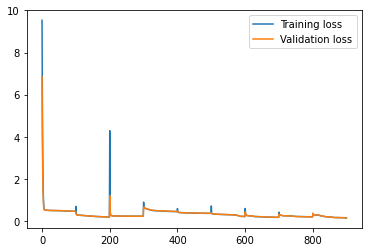

In [11]:
loss_history = []
val_loss_history = []
for i in range(len(history)):
  loss_history.extend(history[i].history["loss"])
  val_loss_history.extend(history[i].history["val_loss"])

plt.plot(loss_history, label='Training loss')
plt.plot(val_loss_history, label='Validation loss')
plt.legend()

In [12]:
X_train, Y_train = buildTrain(df.iloc[9*size: (9+1) * size], features, 'BV_Log')
print('X_train: ',X_train.shape)
print('Y_train: ',Y_train.shape)
print('X_val: ',X_val.shape)
print('Y_val: ',Y_val.shape)
yTrain = np.reshape(Y_train, (Y_train.shape[0], 300, 1))
print(yTrain.shape)
model.evaluate(X_train, yTrain)

X_train:  (1693, 300, 109)
Y_train:  (1693, 300)
X_val:  (338, 300, 109)
Y_val:  (338, 300)
(1693, 300, 1)
53/53 [==============================] - 1s 26ms/step - loss: 0.9652


0.9652391672134399